In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

In [3]:
!pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [4]:

df = pd.read_csv('merged_years1.csv')
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_15961/2267991074.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_years1.csv')


In [107]:
df.head()

,CMTE_ID,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_TP,TRANSACTION_DT,TRANSACTION_AMT
0,C00401224,"EDWARDS, DONALD",SANTA ROSA,CA,95409.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250
1,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250
2,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250
3,C00401224,"EHRENKRANZ, ANDRA",NEW YORK,NY,10021.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250
4,C00401224,"EASTERBROOK, LESLIE",TARZANA,CA,91356.0,NONE,NOT EMPLOYED,24T,1012021,100


In [108]:
df.shape

(45520252, 10)

In [109]:
# Transform TRANSACTION_DT to datetime dtype and store the values in a new column 'transac_date'.

In [110]:
def clean_transaction_dt(value):
    if isinstance(value, (int, float)) and not isinstance(value, bool):
        # If the value is numeric, convert to integer
        return int(value)
    elif isinstance(value, str):
        # If the value is a string, try to convert to integer after removing non-numeric characters
        cleaned_value = ''.join(char for char in str(value) if char.isdigit() or char == '.')
        try:
            return int(float(cleaned_value))
        except ValueError:
            # If conversion fails, return NaN (you can modify this part based on your requirement)
            return float('nan')
    else:
        # If the value is neither numeric nor string, return NaN
        return float('nan')

In [111]:
# Apply the cleaning function to 'TRANSACTION_DT' column
df['TRANSACTION_DT_cleaned'] = df['TRANSACTION_DT'].apply(clean_transaction_dt)

# Drop rows where 'TRANSACTION_DT_cleaned' is NaN
df = df.dropna(subset=['TRANSACTION_DT_cleaned'])

# Convert the cleaned values back to integer if needed
df['TRANSACTION_DT_cleaned'] = df['TRANSACTION_DT_cleaned'].astype(int)

In [112]:
unique_values_lengths_cleaned = df['TRANSACTION_DT_cleaned'].astype(str).apply(len).unique()
print("Unique lengths of values in TRANSACTION_DT_cleaned:", unique_values_lengths_cleaned)

Unique lengths of values in TRANSACTION_DT_cleaned: [7 8]


In [113]:
df['TRANSACTION_DT_cleaned'] = df['TRANSACTION_DT_cleaned'].astype(str)

# Check if the length is 7 and prepend '0' if true
df.loc[df['TRANSACTION_DT_cleaned'].str.len() == 7, 'TRANSACTION_DT_cleaned'] = '0' + df['TRANSACTION_DT_cleaned'] 

df['transac_date'] = pd.to_datetime(df['TRANSACTION_DT_cleaned'], format='%m%d%Y', errors='coerce')

In [114]:
df.head()

,CMTE_ID,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_TP,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_DT_cleaned,transac_date
0,C00401224,"EDWARDS, DONALD",SANTA ROSA,CA,95409.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01
1,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01
2,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01
3,C00401224,"EHRENKRANZ, ANDRA",NEW YORK,NY,10021.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01
4,C00401224,"EASTERBROOK, LESLIE",TARZANA,CA,91356.0,NONE,NOT EMPLOYED,24T,1012021,100,01012021,2021-01-01


In [115]:
# change TRANSACTION_AMT to numerical values and store them in the new column 'donation'.

In [116]:
# Display the value counts for the dtype of values in the 'TRANSACTION_AMT' column
# value_counts_TRANSACTION_AMT_type = df['TRANSACTION_AMT'].apply(lambda x: type(x).__name__).value_counts()
# print(value_counts_TRANSACTION_AMT_type)

In [117]:
df['donation'] = pd.to_numeric(df['TRANSACTION_AMT'], errors='coerce')

In [118]:
df.head()

,CMTE_ID,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_TP,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_DT_cleaned,transac_date,donation
0,C00401224,"EDWARDS, DONALD",SANTA ROSA,CA,95409.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01,250
1,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01,250
2,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01,250
3,C00401224,"EHRENKRANZ, ANDRA",NEW YORK,NY,10021.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01,250
4,C00401224,"EASTERBROOK, LESLIE",TARZANA,CA,91356.0,NONE,NOT EMPLOYED,24T,1012021,100,01012021,2021-01-01,100


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45520236 entries, 0 to 45520251
Data columns (total 13 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   CMTE_ID                 object        
 1   NAME                    object        
 2   CITY                    object        
 3   STATE                   object        
 4   ZIP_CODE                object        
 5   EMPLOYER                object        
 6   OCCUPATION              object        
 7   TRANSACTION_TP          object        
 8   TRANSACTION_DT          object        
 9   TRANSACTION_AMT         object        
 10  TRANSACTION_DT_cleaned  object        
 11  transac_date            datetime64[ns]
 12  donation                int64         
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 5.8+ GB


# Predict the donation amount based on year, month, weekday, and day using Linear Regression Model. 

In [121]:
df['year'] = pd.to_datetime(df.transac_date).dt.year

In [122]:
# df['transac_date'] = pd.to_datetime(df['TRANSACTION_DT_cleaned'], format='%m%d%Y', errors='coerce')

In [123]:
df.shape[0]*.8

36416188.800000004

In [124]:
len(df[df['transac_date'] < '2021-11-05'])

36383964

In [125]:
train_raw = df[df.transac_date < '2021-11-05'].reset_index(drop=True)
test_raw = df[df.transac_date >= '2021-11-05'].reset_index(drop=True)

In [126]:
class DT_Transformer(object):
    
    def fit(self, X, y=None):
        pass
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X.transac_date).dt.year
        df['month'] = pd.to_datetime(X.transac_date).dt.month
        df['weekday'] = pd.to_datetime(X.transac_date).dt.weekday
        df['day'] = pd.to_datetime(X.transac_date).dt.day
        return df
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train = train_raw[["transac_date"]]
y_train = train_raw["donation"]

X_test = test_raw[["transac_date"]]
y_test = test_raw["donation"]

steps = [("dttf", DT_Transformer()), ("lr", LinearRegression())]

model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [128]:
def loss(data, X, y_true, model):
    '''Calculate the MAE, MSE and R2 of data (str) between true and prediction with model'''
    y_pred = model.predict(X)
    print(data, "MAE: {0:.2e}".format(mean_absolute_error(y_true, y_pred)))
    print(data, "MSE: {0:.2e}".format(mean_squared_error(y_true, y_pred)))
    print(data, "R2 score : {0:.3f}".format(r2_score(y_true, y_pred)))

In [129]:
'''Train loss'''

loss("train", X_train, y_train, model)

train MAE: 1.16e+02
train MSE: 2.25e+05
train R2 score : 0.001


In [130]:
'''Test loss'''

loss("test", X_test, y_test, model)

test MAE: 1.11e+02
test MSE: 3.07e+05
test R2 score : 0.000


Text(0, 0.5, 'y_test_pred')

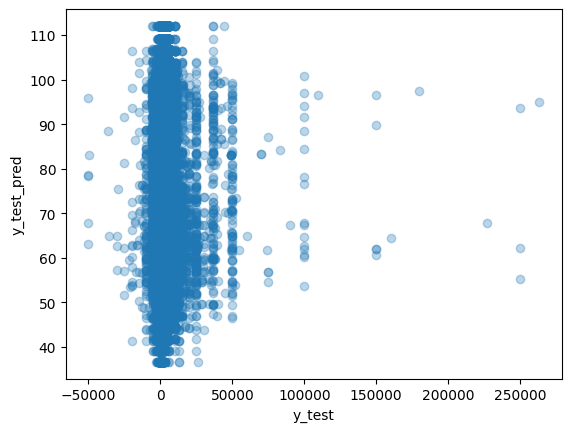

In [131]:
plt.scatter(y_test, model.predict(X_test), alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

# It is the same as random guess when we predict the donation amount based on year, month, weekday, and day using Linear Regression Model. 
# Probably remove this entire linear regression model. 

# It is worse than randome guess to predict the donation amount of the current year based on the donation from the last 3 years using Linear Regression Model. 

# Next, Build a LinearRegression model to predict the monthly donation amount using the monthly donation amount in the past three months. 

In [17]:
df.head()

,CMTE_ID,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_TP,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_DT_cleaned,transac_date,donation
0,C00401224,"EDWARDS, DONALD",SANTA ROSA,CA,95409.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01,250
1,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01,250
2,C00401224,"ELAM NORRIS, GLORIA",CHICAGO,IL,60649.0,UNIV OF IL,PHYSICIAN,24T,1012021,250,01012021,2021-01-01,250
3,C00401224,"EHRENKRANZ, ANDRA",NEW YORK,NY,10021.0,NOT EMPLOYED,NOT EMPLOYED,24T,1012021,250,01012021,2021-01-01,250
4,C00401224,"EASTERBROOK, LESLIE",TARZANA,CA,91356.0,NONE,NOT EMPLOYED,24T,1012021,100,01012021,2021-01-01,100


In [20]:
df_ARI= df[['transac_date','donation']]

In [21]:
df_ARI.head()

,transac_date,donation
0,2021-01-01,250
1,2021-01-01,250
2,2021-01-01,250
3,2021-01-01,250
4,2021-01-01,100


In [24]:
df_ARI.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45520236 entries, 0 to 45520251
Data columns (total 2 columns):
 #   Column        Dtype         
---  ------        -----         
 0   transac_date  datetime64[ns]
 1   donation      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 GB


In [ ]:
# Set 'transac_date' as the index
df_ARI.set_index('transac_date', inplace=True)

In [27]:
df_ARI.head()

,donation
transac_date,
2021-01-01,250
2021-01-01,250
2021-01-01,250
2021-01-01,250
2021-01-01,100


In [142]:
# Resample the data on a monthly basis and calculate the monthly sum
monthly_sum = df_ARI.resample('M').sum()

# Print the resulting DataFrame
print(monthly_sum)

               donation
transac_date           
2017-01-31      4994669
2017-02-28      8448738
2017-03-31     15803863
2017-04-30     12226604
2017-05-31     16254033
...                 ...
2022-08-31     74973974
2022-09-30    106858076
2022-10-31    150459876
2022-11-30     89132774
2022-12-31     14938122

[72 rows x 1 columns]


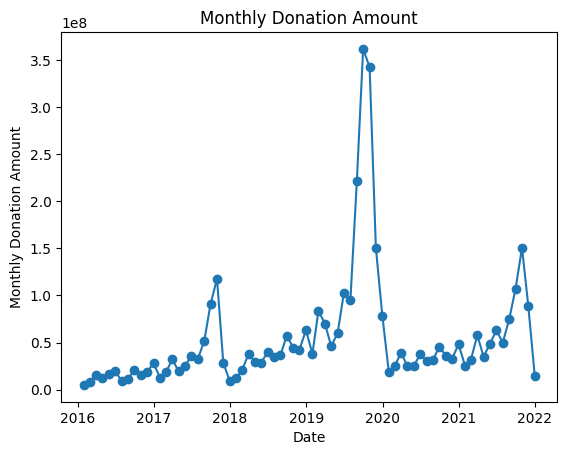

In [143]:
plt.plot(monthly_sum.index, monthly_sum.donation, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Monthly Donation Amount')
plt.title('Monthly Donation Amount')

# Display the plot
plt.show()

In [144]:
df_month = monthly_sum
df_month

,donation
transac_date,
2017-01-31,4994669
2017-02-28,8448738
2017-03-31,15803863
2017-04-30,12226604
2017-05-31,16254033
...,...
2022-08-31,74973974
2022-09-30,106858076
2022-10-31,150459876


In [145]:
len(df_month)

72

In [146]:
df_month.donation.min()

4994669

In [147]:
df_month.donation.max()

361568047

In [148]:
# Retrieve the 'transac_date' value for the 57th row
date_of_57th_row = df_month.index[56]  # Python uses zero-based indexing, so the 57th row corresponds to index 56

print("The 'transac_date' value of the 57th row is:", date_of_57th_row)

The 'transac_date' value of the 57th row is: 2021-09-30 00:00:00


In [149]:
'''linear regression model to predict the yearly average price'''
from sklearn.model_selection import train_test_split

lr_data_month = {
    "donation month-3": df_month.shift(3)["donation"],
    "donation month-2": df_month.shift(2)["donation"],
    "donation month-1": df_month.shift(1)["donation"],
    "donation": df_month["donation"]
}
lr_df_month = pd.DataFrame(lr_data_month).dropna()

df_train = lr_df_month[lr_df_month.index <= '2021-09-30']
df_test = lr_df_month[lr_df_month.index > '2021-09-30']

X_train, y_train = df_train.iloc[:, :3], df_train["donation"]
X_test, y_test = df_test.iloc[:, :3], df_test["donation"]

In [150]:
lr_df_month.head()

,donation month-3,donation month-2,donation month-1,donation
transac_date,,,,
2017-04-30,4994669.0,8448738.0,15803863.0,12226604
2017-05-31,8448738.0,15803863.0,12226604.0,16254033
2017-06-30,15803863.0,12226604.0,16254033.0,19888368
2017-07-31,12226604.0,16254033.0,19888368.0,9142026
2017-08-31,16254033.0,19888368.0,9142026.0,11257800


In [151]:
df_train

,donation month-3,donation month-2,donation month-1,donation
transac_date,,,,
2017-04-30,4994669.0,8448738.0,15803863.0,12226604
2017-05-31,8448738.0,15803863.0,12226604.0,16254033
2017-06-30,15803863.0,12226604.0,16254033.0,19888368
2017-07-31,12226604.0,16254033.0,19888368.0,9142026
2017-08-31,16254033.0,19888368.0,9142026.0,11257800
2017-09-30,19888368.0,9142026.0,11257800.0,21118567
2017-10-31,9142026.0,11257800.0,21118567.0,16038775
2017-11-30,11257800.0,21118567.0,16038775.0,18762207
2017-12-31,21118567.0,16038775.0,18762207.0,27982059


In [152]:
df_test

,donation month-3,donation month-2,donation month-1,donation
transac_date,,,,
2021-10-31,30461521.0,31717289.0,45679597.0,35999454
2021-11-30,31717289.0,45679597.0,35999454.0,32689230
2021-12-31,45679597.0,35999454.0,32689230.0,48148823
2022-01-31,35999454.0,32689230.0,48148823.0,25448717
2022-02-28,32689230.0,48148823.0,25448717.0,31590373
2022-03-31,48148823.0,25448717.0,31590373.0,57673026
2022-04-30,25448717.0,31590373.0,57673026.0,35051277
2022-05-31,31590373.0,57673026.0,35051277.0,48683112
2022-06-30,57673026.0,35051277.0,48683112.0,62879250


In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# train the model

lr_model_month = LinearRegression()
lr_model_month = lr_model_month.fit(X_train, y_train)

In [154]:
'''Train loss'''
loss("train", X_train, y_train, lr_model_month)

train MAE: 2.18e+07
train MSE: 1.28e+15
train R2 score : 0.733


In [155]:
'''Test loss'''

loss("test", X_test, y_test, lr_model_month)

test MAE: 2.31e+07
test MSE: 7.48e+14
test R2 score : 0.367


Text(0, 0.5, 'y_test_pred')

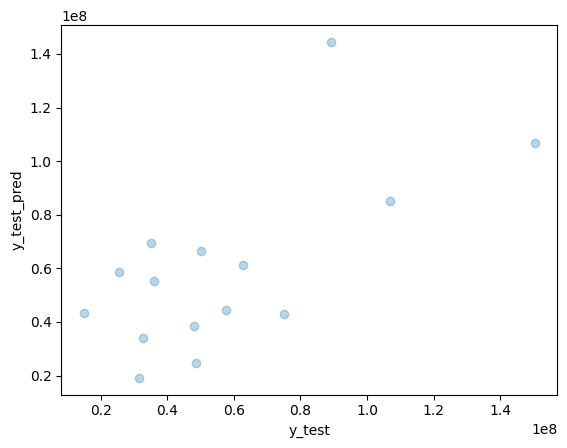

In [156]:
plt.scatter(y_test, lr_model_month.predict(X_test), alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

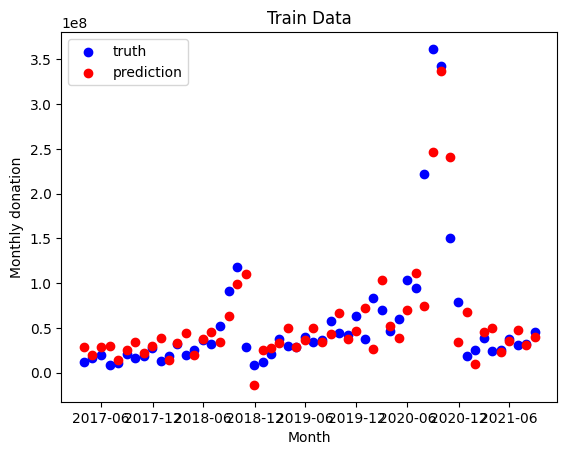

In [159]:
# Plot the prediction and ground truth of monthly culmulative doantion amount against time.

'''Train'''

plt.scatter(X_train.index, y_train, color="b", label="truth")
plt.scatter(X_train.index, lr_model_month.predict(X_train), color="r", label="prediction")
plt.xlabel("Month")
plt.ylabel("Monthly donation")
plt.title("Train Data")
plt.legend()

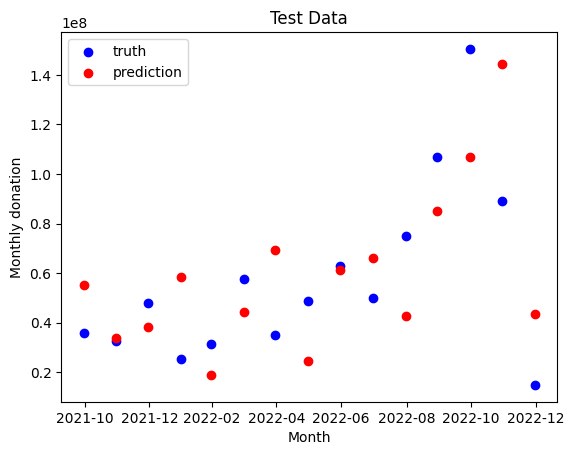

In [160]:
'''Test'''

plt.scatter(X_test.index, y_test, color="b", label="truth")
plt.scatter(X_test.index, lr_model_month.predict(X_test), color="r", label="prediction")
plt.xlabel("Month")
plt.ylabel("Monthly donation")
plt.title("Test Data")
plt.legend()

In [ ]:
#ARIMA

In [161]:
df_train = df_month[df_month.index <= '2021-09-30']
df_test = df_month[df_month.index > '2021-09-30']

ADF Statistic: -4.356265
p-value: 0.000354
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Series is stationary


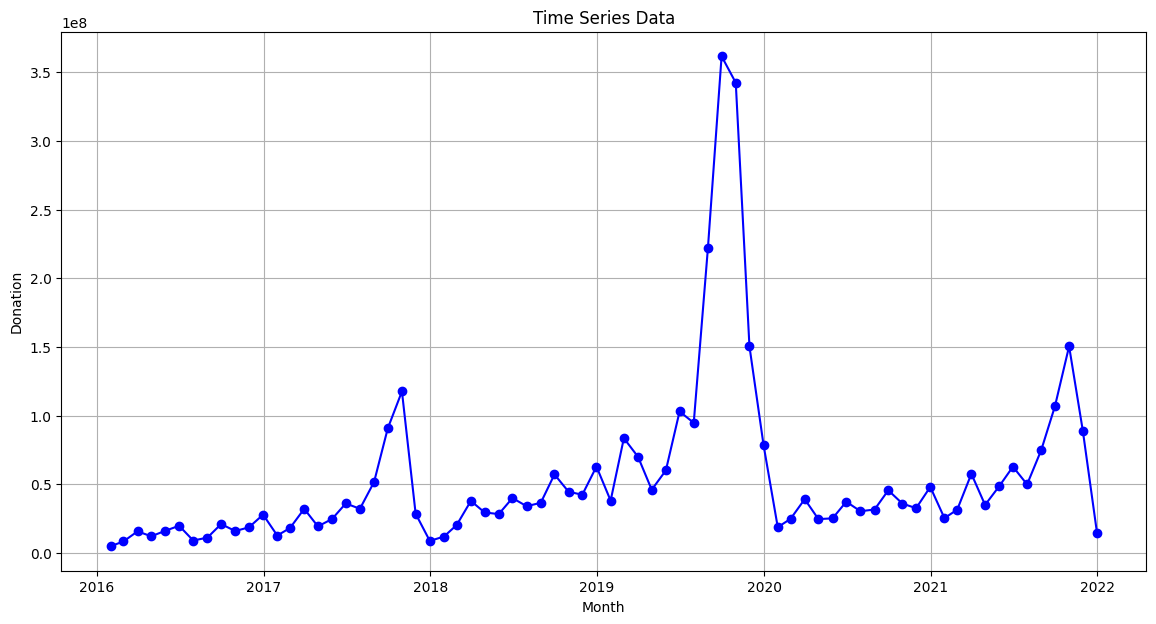

In [162]:
import statsmodels.api as sm

#  test for Stationarity
# Conduct the Augmented Dickey-Fuller test
result = sm.tsa.adfuller(df_month['donation'])

# Output the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

# Plotting the time series data
plt.figure(figsize=(14, 7))
plt.plot(df_month.index, df_month['donation'], marker='o', linestyle='-', color='b')
plt.title('Time Series Data')
plt.xlabel('Month')
plt.ylabel('Donation')
plt.grid(True)
plt.show()


In [67]:
 # If the data was not stationary, try 'Differencing' to make the data stationary before applying an ARIMA model
#Take the first difference (subtracting the previous value from the current one) of the series.
# df_train['diff_1'] = df_train['donation'].diff(1)

#  retest for Stationarity
# Conduct the Augmented Dickey-Fuller test

# df_train = df_train.dropna()
# result = sm.tsa.adfuller(df_train['diff_1'] )

# # Output the results
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

# # Interpretation
# if result[1] > 0.05:
#     print("Series is not stationary")
# else:
#     print("Series is stationary")

# # Plotting the time series data
# plt.figure(figsize=(14, 7))
# plt.plot(df_train.index, df_train['diff_1'] , marker='o', linestyle='-', color='b')
# plt.title('Time Series Data')
# plt.xlabel('Date')
# plt.ylabel('Donation')
# plt.grid(True)
# plt.show()

In [ ]:
# find p, q 

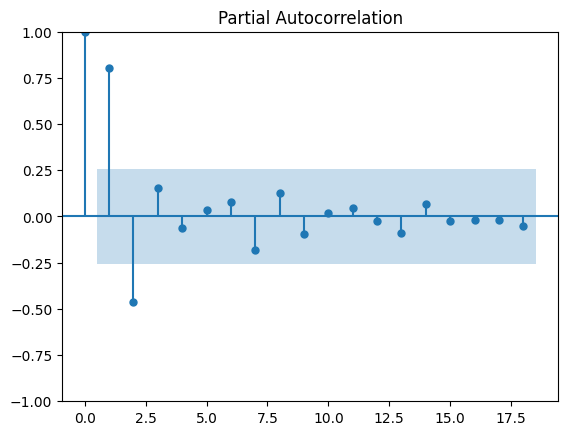

In [163]:
# pacf plot to determine p for AR

plot_pacf(df_train['donation'])
plt.show()

# sharp cut after 3 lags, p = 3

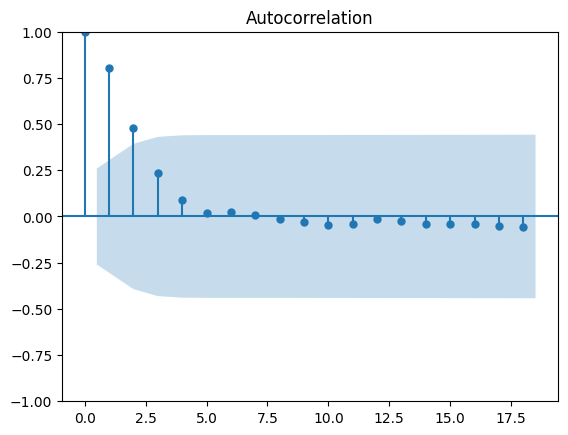

In [164]:
# acf plot to determine q for MA

plot_acf(df_train['donation'])
plt.show()

# seems to be a sharp cut after the 2nd line, q = 2 ? (Please double check)

In [ ]:
# build ARIMA model

In [79]:
# codes from class  notebook.
# from statsmodels.tsa.arima_model import ARIMA
# import numpy as np

# # fit model
# model_arima = ARIMA(df_train['diff_1'], order=(3,1,2)) # order = (p, d, q)
# model_arima = model_arima.fit(disp=-1)

In [165]:
import statsmodels.api as sm

# Example orders (replace with your identified orders)
p, d, q = 3, 0, 2

# Initialize and fit ARIMA model
model_arima = sm.tsa.ARIMA(df_train['donation'], order=(p, d, q))
model_arima = model_arima.fit()

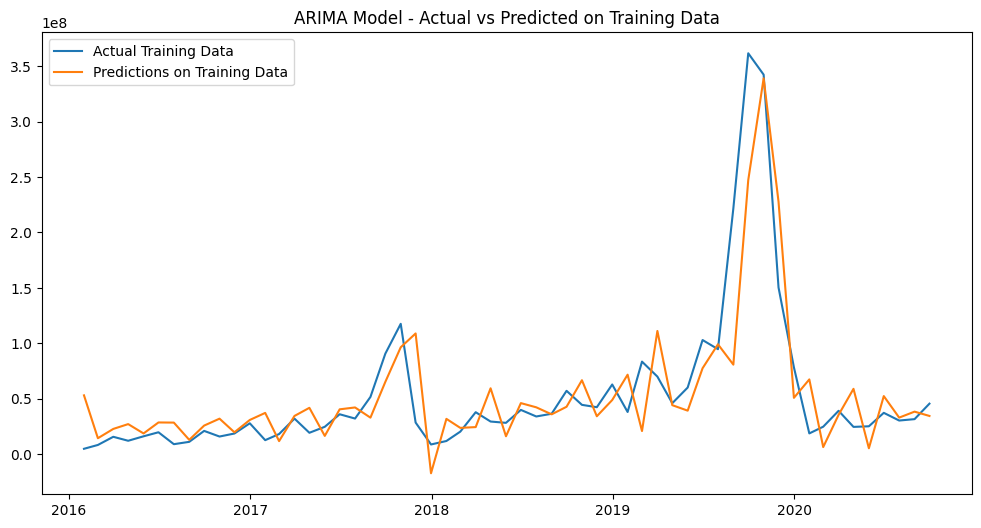

In [166]:
# Make in-sample predictions on the training set
df_train['predictions'] = model_arima.predict(start=df_train.index.min(), end=df_train.index.max(), dynamic=False)

# Plot the actual vs predicted values on the training set
plt.figure(figsize=(12, 6))
plt.plot(df_train['donation'], label='Actual Training Data')
plt.plot(df_train['predictions'], label='Predictions on Training Data')
plt.title('ARIMA Model - Actual vs Predicted on Training Data')
plt.legend()
plt.show()

In [167]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming df_train['donation'] contains the actual values and df_train['predictions'] contains the predicted values
actual_values = df_train['donation']
predicted_values = df_train['predictions']

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1197021010629367.0
Root Mean Squared Error (RMSE): 34597991.42478313
Mean Absolute Error (MAE): 21933060.218301646


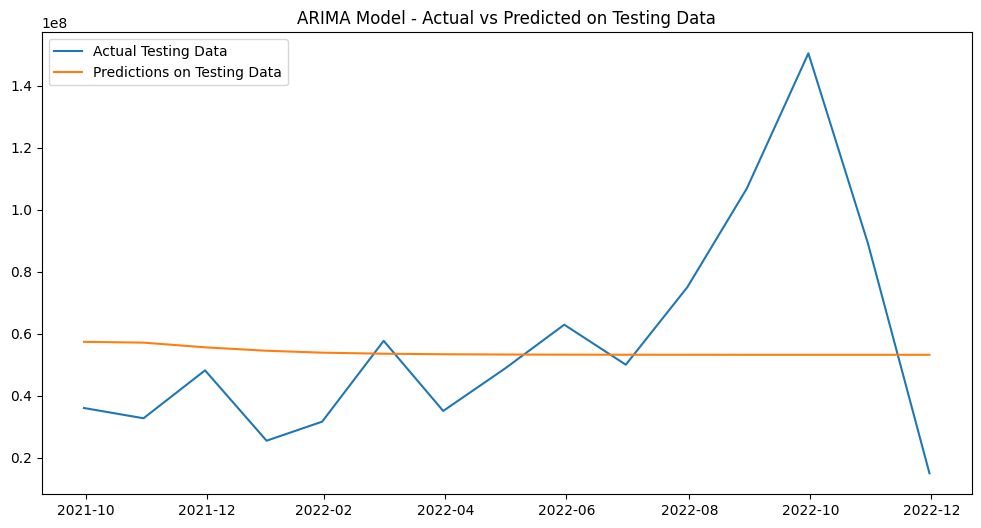

In [168]:
# Make in-sample predictions on the training set
# df_train['predictions'] = model_arima.predict(start=df_train.index.min(), end=df_train.index.max(), dynamic=False)
# Apply the same differencing to df_test if we use differencing for the train data.
# df_test['diff_1']= df_test['donation'].diff(1).dropna() 


df_test['predictions'] = model_arima.predict(start=df_test.index.min(), end=df_test.index.max(), dynamic=False)  # (Is this correct, please double check!)

# Plot the actual vs predicted values on the training set
plt.figure(figsize=(12, 6))
plt.plot(df_test['donation'], label='Actual Testing Data')
plt.plot(df_test['predictions'], label='Predictions on Testing Data')
plt.title('ARIMA Model - Actual vs Predicted on Testing Data')
plt.legend()
plt.show()


In [169]:
actual_values_test = df_test['donation']
predicted_values_test = df_test['predictions']

# Calculate Mean Squared Error (MSE)
mse_test = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse_test = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae_test = mean_absolute_error(actual_values, predicted_values)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test}')
print(f'Mean Absolute Error (MAE): {mae_test}')

Mean Squared Error (MSE): 1197021010629367.0
Root Mean Squared Error (RMSE): 34597991.42478313
Mean Absolute Error (MAE): 21933060.218301646


In [ ]:
# below is not done

In [ ]:
# you can use TimeSeriesSplit to split the train/test and do cross_validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit() 

In [99]:
df_month.head()

,donation
transac_date,
2017-01-31,4994669
2017-02-28,13443407
2017-03-31,29247270
2017-04-30,41473874
2017-05-31,57727907


In [ ]:
#hyper parameter tuning
for train_index, test_index in tscv.split(df_month):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = lr_df.iloc[train_index,1:4], lr_df.iloc[test_index,1:4]
    y_train, y_test = lr_df.iloc[train_index,0], lr_df.iloc[test_index,0]
    model = LinearRegression().fit(X_train, y_train)
#take average model performance metric